In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

In [10]:
df = pd.read_csv('cleaned_data.csv')
df["Insulin"] = df["Insulin\n(Yes / No)"]
df = df.drop(columns=["Insulin\n(Yes / No)"], axis=1)
df

,Case NO,Age,LDL,Statin Used,Statin Medications,Statin Dose,Current Smoker,Gender,BMI,WC,...,Diabetes,Hyperlipidemia,Hypertension,Ischemic Stroke,No Secondary Diseases,Obesity,Obstructive Sleep Apnea,Peripheral Artery Disease,Primary Hypothyroidism,Insulin
0,1,75,179.0,yes,Fluvastatin,42.0,False,male,41.0,38.0,...,0,1,0,1,0,0,0,0,0,Yes
1,2,63,116.0,yes,Fluvastatin,50.0,False,female,26.0,23.0,...,0,0,0,1,0,0,0,0,0,Yes
2,3,49,142.0,yes,Fluvastatin,72.0,False,male,34.0,40.0,...,0,0,0,0,0,0,0,0,0,Yes
3,4,77,74.0,no,No Statin Medication,0.0,True,female,33.0,21.0,...,0,0,0,0,0,0,0,0,0,Yes
4,5,42,151.0,yes,Atorvastatin,45.0,False,male,37.0,23.0,...,0,0,0,0,0,0,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,899,39,69.0,yes,Atorvastatin,13.0,True,male,26.0,36.0,...,0,0,0,0,0,0,0,0,0,Yes
899,900,56,128.0,no,No Statin Medication,0.0,False,male,26.0,40.0,...,0,0,0,0,1,0,0,0,0,Yes
900,901,53,87.0,no,No Statin Medication,0.0,False,female,25.0,28.0,...,1,0,0,0,0,0,1,0,0,Yes
901,902,81,104.0,yes,Pravastatin,33.0,False,male,23.0,54.0,...,0,0,0,0,0,0,0,0,0,No


In [11]:
df['LDL_Statin_Interact'] = df['LDL'].mul(df['Statin Dose'])

# Feature Selection

## $1^{st}$ Embedded methods

### Using L1 (Lasso) Regression

In [12]:
# Get the list of categorical columns
categorical_cols = df.drop(columns=['target'], axis=1).select_dtypes(include=['object']).columns

# Convert categorical columns into dummy variables
df_encoded = pd.get_dummies(df, columns=categorical_cols)

In [13]:
X = df_encoded.drop(columns='target')
y = df_encoded['target']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply one-hot encoding to the target variable
encoder = OneHotEncoder(sparse_output=False)  # the output will be a dense array
y_encoded = encoder.fit_transform(y.values.reshape(-1, 1))

# Apply MultiTaskLassoCV for feature selection
lasso = MultiTaskLassoCV(cv=5, random_state=42, n_jobs=-1, eps=0.01)
lasso.fit(X_scaled, y_encoded)

# Get the coefficients for each task (class)
lasso_coefficients = pd.DataFrame(lasso.coef_, columns=X.columns, index=encoder.categories_[0])

# Calculate the importance of each feature as the mean absolute value of its coefficients across tasks
feature_importance = lasso_coefficients.abs().mean(axis=0)

# Select features with importance above a threshold (e.g., mean importance)
threshold = feature_importance.mean()
selected_features_l1 = feature_importance[feature_importance >= threshold]

sorted_importance = selected_features_l1.sort_values(ascending=False)


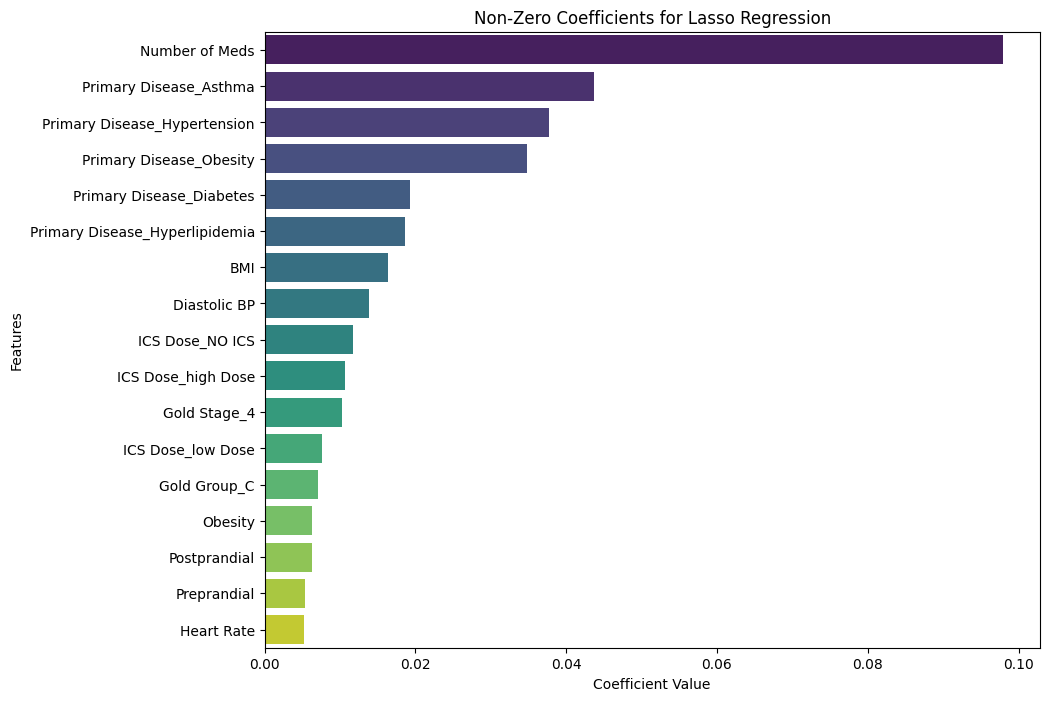

In [14]:
# Prepare the data for plotting
plot_data_l1 = pd.DataFrame({'Feature': sorted_importance.index, 'Coefficient Value': sorted_importance.values})

# Plot the non-zero coefficients in ascending order using Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient Value', y='Feature', data=plot_data_l1, palette='viridis', hue='Feature', dodge=False, legend=False)
plt.title('Non-Zero Coefficients for Lasso Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()

### Random Forest Feature Importance

In [15]:
# Initialize RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_

# Convert importances to a Series for easy visualization
feature_importances = pd.Series(importances, index=X.columns)

# Select features with importance above a threshold (e.g., mean importance)
threshold = feature_importances.mean()
selected_features_rf = feature_importances[feature_importances >= threshold]


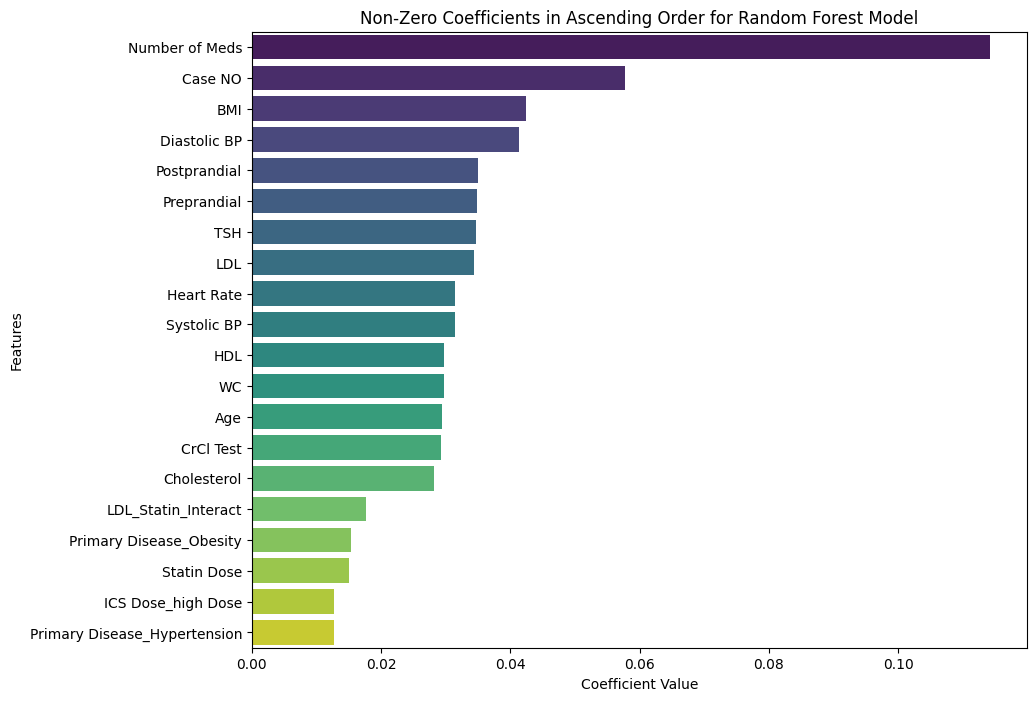

In [16]:
# Sort the feature importances in descending order for better visualization
sorted_importances = selected_features_rf.sort_values(ascending=False)

# Prepare the data for plotting
plot_data_rf = pd.DataFrame({'Feature': sorted_importances.index, 'Coefficient Value': sorted_importances.values})

# Plot the non-zero coefficients in ascending order using Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient Value', y='Feature', data=plot_data_rf, palette='viridis', hue='Feature', dodge=False, legend=False)
plt.title('Non-Zero Coefficients in Ascending Order for Random Forest Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()

## $2^{nd}$ Wrapper methods

### Recursive Feature Elimination & Exhaustive Feature Selection

In [17]:
from sklearn.model_selection import StratifiedKFold

def apply_wrapper(X, y, cv=5, method="rfe"):
    """
    Applies Recursive Feature Elimination (RFE) or Exhaustive Feature Selection (EFS) to select features.

    Parameters:
    X (pd.DataFrame): The feature matrix.
    y (pd.Series): The target vector.
    cv (int or cross-validation generator): Determines the cross-validation splitting strategy.
    method (str): The method to use for feature selection. Can be either "rfe" or "efs".

    Returns:
    list: List of selected feature names.
    """

    # Initialize the estimator with a random state
    estimator = DecisionTreeClassifier(random_state=42)

    if method == "rfe":
        rfe = RFECV(estimator, cv=cv)
        # Fit RFE
        rfe.fit(X, y)
        selected_features = X.columns[rfe.support_].tolist()

    elif method == "efs":
        # Initialize EFS with a RandomForestClassifier as estimator
        efs = EFS(estimator, cv=cv, min_features=1, max_features=10)
        # Fit EFS
        efs.fit(X, y)
        selected_features = efs.best_feature_names_

    return selected_features

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Use StratifiedKFold to ensure consistent cross-validation splits
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

# Apply feature selection with RFE
selected_features_rfe = apply_wrapper(X_train, y_train, cv=cv, method="rfe")

print("Selected Features using RFE:", selected_features_rfe)
print("Number of Selected Features for RFE:", len(selected_features_rfe))
print("Number of dropped features for RFE:", X_train.shape[1] - len(selected_features_rfe))

Selected Features using RFE: ['Case NO', 'Age', 'LDL', 'Statin Dose', 'Current Smoker', 'BMI', 'WC', 'HDL', 'Cholesterol', 'CrCl Test', 'TSH', 'Systolic BP', 'Diastolic BP', 'Postprandial', 'Preprandial', 'Number of Meds', 'Heart Rate', 'Aortic Aneurysm', 'Asthma', 'CKD', 'COPD', 'Carotid Artery Disease', 'Coronary Artery Disease', 'Diabetes', 'Hypertension', 'Ischemic Stroke', 'No Secondary Diseases', 'Peripheral Artery Disease', 'Primary Hypothyroidism', 'LDL_Statin_Interact', 'Primary Disease_Asthma', 'Primary Disease_COPD', 'Primary Disease_Diabetes', 'Primary Disease_Hyperlipidemia', 'Primary Disease_Hypertension', 'Primary Disease_Obesity', 'Primary Disease_Primary Hypothyroidism', 'Gold Stage_1', 'Gold Stage_2', 'Gold Stage_3', 'Gold Stage_4', 'Gold Stage_unknown', 'Gold Group_A', 'Gold Group_B', 'Gold Group_C', 'Gold Group_D', 'Gold Group_Unknown', 'COPD Pills_no', 'COPD Pills_yes', 'Asthma Controlled_partially controlled', 'Asthma Controlled_poorly controlled', 'Asthma Control

### Model with selected Features Using RFE

In [18]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Label encoding
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

dt = DecisionTreeClassifier(random_state=42)

# Define parameter grid for grid search
param_grid_dt = {
    'max_depth': [3, 4, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'class_weight': [None, 'balanced']
}

# Grid search with cross-validation
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=cv, scoring='accuracy', n_jobs=-1)

# Fit the grid search model
grid_search_dt.fit(X_train[selected_features_rfe], y_train)
y_pred = grid_search_dt.predict(X_test[selected_features_rfe])
dt_cm = confusion_matrix(y_test, y_pred)

# Print best parameters and classification report
print("Decision Tree - Best Parameters:", grid_search_dt.best_params_)
print("Decision Tree - Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))
print("Decision Tree - Accuracy:", accuracy_score(y_test, y_pred))

Decision Tree - Best Parameters: {'class_weight': None, 'max_depth': 20, 'min_samples_split': 5}
Decision Tree - Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.72      0.71        58
           1       0.71      0.86      0.78        29
           2       0.78      0.73      0.76        70
           3       1.00      1.00      1.00         4
           4       0.53      0.45      0.49        20

    accuracy                           0.72       181
   macro avg       0.75      0.75      0.75       181
weighted avg       0.72      0.72      0.72       181

Decision Tree - Accuracy: 0.7237569060773481


### Model without Feature Selection

In [20]:
# Fit the grid search model
grid_search_dt.fit(X_train, y_train)
y_pred = grid_search_dt.predict(X_test)
dt_cm = confusion_matrix(y_test, y_pred)

# Print classification report and accuracy
print("Decision Tree - Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))
print("Decision Tree - Accuracy:", accuracy_score(y_test, y_pred))

Decision Tree - Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.72      0.70        58
           1       0.68      0.79      0.73        29
           2       0.76      0.71      0.74        70
           3       0.00      0.00      0.00         4
           4       0.47      0.45      0.46        20

    accuracy                           0.69       181
   macro avg       0.52      0.54      0.53       181
weighted avg       0.67      0.69      0.68       181

Decision Tree - Accuracy: 0.6850828729281768


## Saving data with selected features

In [21]:
data_rfe = df_encoded[selected_features_rfe]
data_rfe["target"] = df_encoded["target"]
# Save the cleaned DataFrame to a CSV file
data_rfe.to_csv('data_RFE.csv', index=False)

<ipython-input-21-3da37c0dc46d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rfe["target"] = df_encoded["target"]
